In [5]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [6]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [7]:
def trial(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

<IPython.core.display.Javascript object>


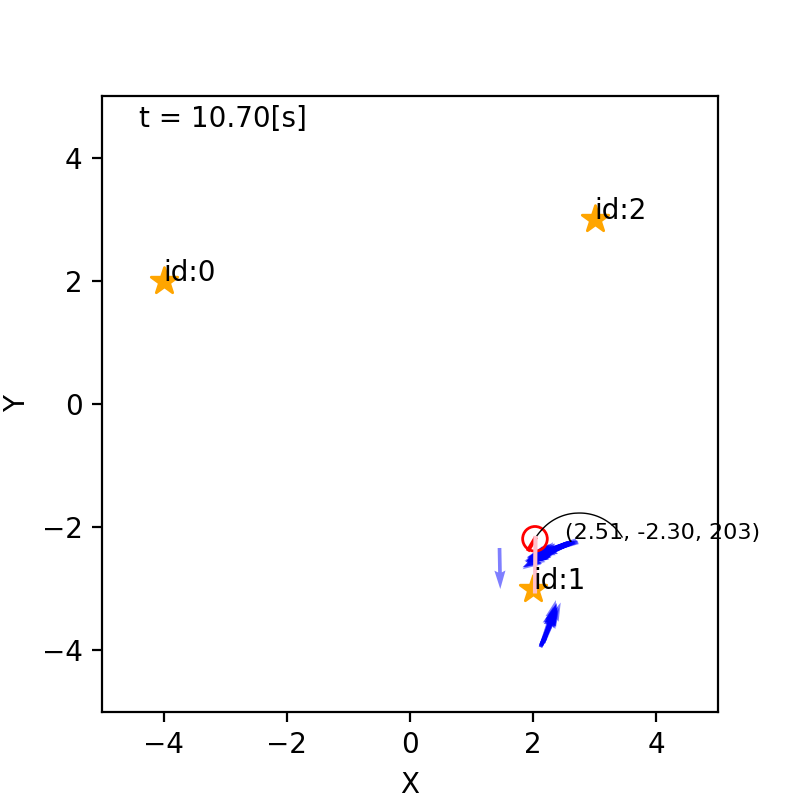

(array([ 3.44333121, -2.15937893,  2.11245047]),
 array([ 1.05602284, -2.04547176,  1.70480613]))

In [8]:
trial(True)

In [10]:
def trial_phantom(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m, phantom_prob=0.1), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

<IPython.core.display.Javascript object>


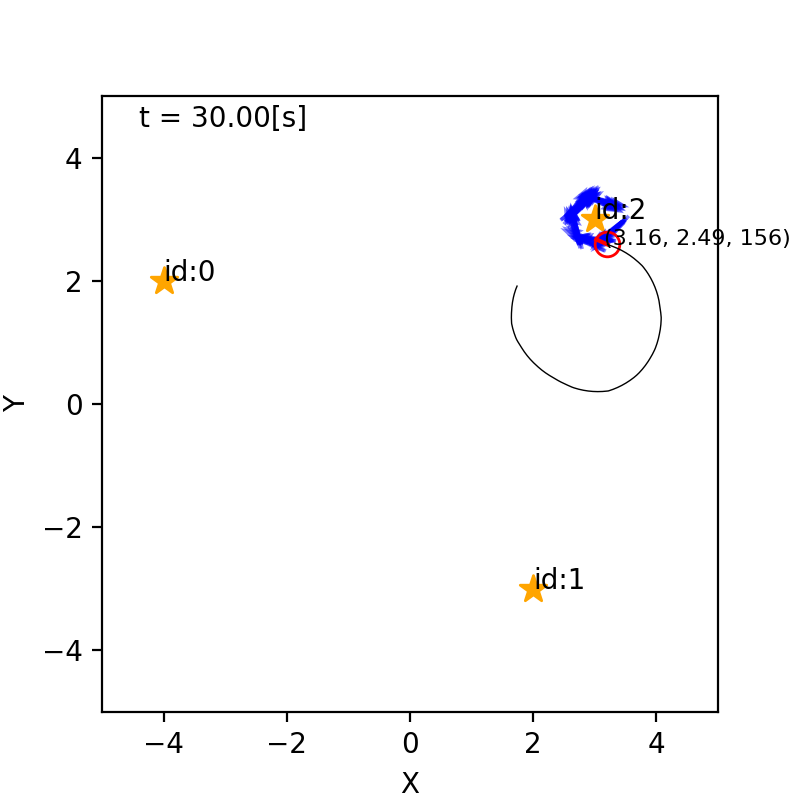

(array([ 1.73789763,  1.913907  , -1.98934091]),
 array([ 3.13557838, -4.5397074 , -1.56885766]))

In [12]:
trial_phantom(True)